# K-Nearest Neighbors Homework Solutions
***
**Name**: **Amith Gopal**
***

This assignment is due on Moodle by **5pm on Friday January 26th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

<br>

![Samples of Handwritten Digits](wide_mnist.png "MNIST Digits")


<br>

This homework is designed to be pretty easy. If you're spending a ton of time on this assignment, then you are either:

- not prepared to take this course (i.e., if you're struggling with Python)
- seriously over-thinking the assignment
- trying to implement too much of KNN from scratch


Most of this assignment will be done by calling libraries that are already implemented for you. If you are implementing $n$-dimensional search or your own distance metrics, you are generating extra work for yourself and making yourself vulnerable to errors. 

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [97]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1
***

The class below will load and store the MNIST data.  Load the data and then report: 
- The number of examples in the training set 
- The number of examples in the test set 
- The number of pixels in each image. 

In [98]:
class Numbers:
    """
    Class to store MNIST data
    """
    def __init__(self, location):

        import pickle, gzip

        # load data from file 
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        print("The number of examples in the training set : ", len(train_set[0]))
        print("The number of examples in the test set : ", len(test_set[0]))
        print("The number of pixels in each image : ", len(train_set[0][0]))
        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

In [99]:
data = Numbers("../data/mnist.pklz")

The number of examples in the training set :  50000
The number of examples in the test set :  10000
The number of pixels in each image :  784


### [30 points] Problem 2
***

The class below will perform K-Nearest Neighbor classification on our handwritten digit data. Your tasks are as follows:   

1. Modify the `label_counts` function to return a dictionary of frequencies corresponding to each label in the training set. 
1. Modify the `majority` function so that it returns the _label_ that appears most frequently in the $K$-nearest neighbors of the query point.  In the case that the maximum frequency occurs for two or more labels, return the one that appears most frequently in the entire training set. In the case that there is still a tie, break the tie in any way that you choose. 
1. Modify the `classify` function so that it finds the _indices_ of the $K$ closest training examples to the query point and then calls the `majority` function to return the predicted label. Almost all of the heavy lifting here will be done by the BallTree object from `sklearn.neighbors`, so you'll want to start out by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).  
1. Modify the `confusion_matrix` function to classify examples and record the results in a confusion matrix. You should construct the confusion matrix on your own.  Don't call any additional functions from sklearn to do it for you.

The class Knearest also implements an `accuracy` function which you will use in **Problem 3**.  You should not have to modify this function. 

We've given you unit tests down below based on the simple example worked out in lecture.  At first your code will fail all of them.  Do not move on to **Problem 3** until your code passes all of the unit tests. In addition, passing the unit tests does not guarantee that your implementation is robust and that you'll earn full points on this problem.  You should be designing your own additional tests as well. 

In [100]:
class Knearest:
    """
    kNN classifier
    """

    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance

        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """
        
        from sklearn.neighbors import BallTree

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
    def label_counts(self):
        """
        Given the training labels, return a dictionary d where d[y] is  
        the number of times that label y appears in the training set. 
        """
        d = {}
        for l in self._y:
            if l not in d:
                d[l] = 1
            else:
                d[l] += 1
            
        #return dict({1:0, -1:0})
        return d
    
    def majority(self, neighbor_indices):
        """
        Given the indices of training examples, return the majority label. Break ties 
        by choosing the tied label that appears most often in the training data. 

        :param neighbor_indices: The indices of the k nearest neighbors
        """
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"
        #print(neighbor_indices)
        
        majority_dict = {}
        for n in neighbor_indices:
            label = self._y[n]
            #print(label)
            if label not in majority_dict:
                majority_dict[label] = []
                majority_dict[label].append(n)
            else:
                majority_dict[label].append(n)
        
        #till here, maintained a majority dict which will store the 
        #key as the label and all the values as a list of the neighbors
        #problem is to return the majority label
        
        max_len = 0
        for k in majority_dict:
            if len(majority_dict[k]) > max_len:
                max_len = len(majority_dict[k])
        
        
        
        #print("MAX LEN", max_len)
        #print(majority_dict)
        
        majority_label_list = []
        for k in majority_dict:
            if len(majority_dict[k]) == max_len:
                majority_label_list.append(k)
        
        if len(majority_label_list) == 1:
#             print(majority_label_list[0])
            return majority_label_list[0]
        else:
            max_label = None
            max_label_count = 0
            #print(majority_label_list)
            for ml in majority_label_list:
                if self._counts[ml] > max_label_count:
                    max_label_count = self._counts[ml]
                    max_label = ml
            #print(max_label)
            return max_label
                    
        #return self._y[neighbor_indices[0]]
    

    def classify(self, example):
        """
        Given an example, return the predicted label. 

        :param example: A representation of an example in the same
        format as a row of the training data
        """
        dist, indices = self._kdtree.query([example], self._k)
        #print(indices)
        return self.majority(indices[0])
        #return self.majority([np.random.randint(0,10) for ii in range(self._k)])


    def confusion_matrix(self, test_x, test_y):
        """
        Given a matrix of test examples and labels, compute the confusion
        matrix for the current classifier.  Should return a 2-dimensional
        numpy array of ints, C, where C[ii,jj] is the number of times an 
        example with true label ii was labeled as jj.

        :param test_x: test data 
        :param test_y: true test labels 
        """
        
        C = np.zeros((10,10), dtype=int)
        count=0
        for xx, yy in zip(test_x, test_y):
            res_label = self.classify(xx)
            C[yy][res_label] += 1
            
            '''
            if yy == 2 and res_label == 7:
                print("2 and 7: ", count)
            if yy == 4 and res_label == 9:
                print("4 and 9: ", count)
            if yy == 8 and res_label == 3:
                print("8 and 3: ", count)     
            count += 1
            '''
             
        return C 
            
    @staticmethod
    def accuracy(C):
        """
        Given a confusion matrix C, compute the accuracy of the underlying classifier.
        
        :param C: a confusion matrix 
        """
        
        return np.sum(C.diagonal()) / C.sum()
        

Here are the unit tests.  You don't need to modify them.  Simply execute the cell and observe the output. 

In [101]:
import unittest

class TestKnn(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[2, 0], [4, 1], [6, 0], [1, 4], [2, 4], [2, 5], [4, 4], [0, 2], [3, 2], [4, 2], [5, 2], [5, 5]])
        self.y = np.array([+1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1])
        self.knn = {}
        for ii in [1, 2, 3]:
            self.knn[ii] = Knearest(self.x, self.y, ii)

        self.queries = np.array([[1, 5], [0, 3], [6, 4]])
        
    def test0(self):
        """
        Test the label counter 
        """
        self.assertEqual(self.knn[1]._counts[-1], 5)
        self.assertEqual(self.knn[1]._counts[1], 7)

    def test1(self):
        """
        Test 1NN
        """
        self.assertEqual(self.knn[1].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[1].classify(self.queries[1]), -1)
        self.assertEqual(self.knn[1].classify(self.queries[2]), -1)

    def test2(self):
        """
        Test 2NN
        """
        #print("TEST 2 started")
        self.assertEqual(self.knn[2].classify(self.queries[0]),  1)
        #print("TEST 2a over")
        self.assertEqual(self.knn[2].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[2]),  1)

    def test3(self):
        """
        Test 3NN
        """
        self.assertEqual(self.knn[3].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[2]), -1)
        
tests = TestKnn()
tests_to_run = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(tests_to_run)

....
----------------------------------------------------------------------
Ran 4 tests in 0.005s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### [15 points] Problem 3
***

In this problem you'll explore the performance of the classifier you've written.  A word of advice: don't use the entire training set, especially at first.  We'll be using this dataset again later on with techniques that scale better.    

**Part A**: Explore the relationship between the number of training examples and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

Training sample :  1000  and Accuracy :  0.8793
Training sample :  5000  and Accuracy :  0.9377
Training sample :  10000  and Accuracy :  0.9558
Training sample :  15000  and Accuracy :  0.9544
Training sample :  20000  and Accuracy :  0.9624
Training sample :  25000  and Accuracy :  0.9622
Training sample :  30000  and Accuracy :  0.9678
Training sample :  35000  and Accuracy :  0.9677
Training sample :  40000  and Accuracy :  0.9695
Training sample :  45000  and Accuracy :  0.9692
Training sample :  50000  and Accuracy :  0.9713


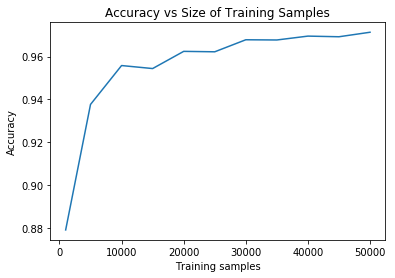

In [102]:
#number of training examples vs accuracy
import random

t_samples = [1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
accuracy_l = []

for training_samples in t_samples:
    random_indices = random.sample(range(0, 50000), training_samples)
    #print(random_indices)
    training_set_list = []
    training_out_list = []
    
    training_set_list = data.train_x[random_indices, :]
#     print(training_set_list)
    training_out_list = data.train_y[random_indices]

    
    knn = Knearest (training_set_list, training_out_list)
    
    cm = knn.confusion_matrix(data.test_x, data.test_y)
#     print(cm)
    print("Training sample : ", training_samples, " and Accuracy : ", knn.accuracy(cm))
    accuracy_l.append(knn.accuracy(cm))
    
plt.plot(t_samples, accuracy_l)
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Size of Training Samples")
plt.legend()
plt.show()
plt.close()


        
    






We can observe from the graph that as the training samples increases, the accuracy also increases.
The reason for this is that for lower training samples, the pixels covered in the 28 x 28 space will be less.
As the training data increases, the pixel space is covered more and more points will be under consideration for the nearest neighbor which gives a better accuracy.

**Part B**: Explore the relationship between the number of nearest neighbors and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

Accuracy :  0.9712
Accuracy :  0.9642
Accuracy :  0.9717
Accuracy :  0.9702
Accuracy :  0.9713
Accuracy :  0.97
Accuracy :  0.9713
Accuracy :  0.9694
Accuracy :  0.9704
Accuracy :  0.9684
Accuracy :  0.9658


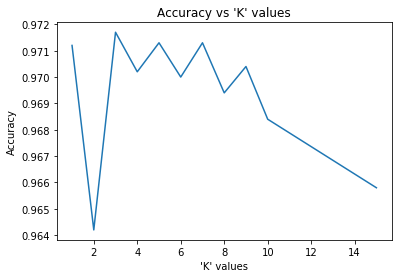

In [81]:
#KNN

k_val_l = [1,2,3,4,5,6,7,8,9,10,15]
accuracy_l = []

for k_val in k_val_l:
    knn = Knearest (data.train_x, data.train_y, k_val)
    cm = knn.confusion_matrix(data.test_x, data.test_y)
    print("'K' : ", k_val, " and Accuracy : ", knn.accuracy(cm))
    accuracy_l.append(knn.accuracy(cm))


plt.plot(k_val_l, accuracy_l)
plt.xlabel("'K' values")
plt.ylabel("Accuracy")
plt.title("Accuracy vs 'K' values")
plt.legend()
plt.show()
plt.close()


We can observe from the graph that as the accuracy remains high for high values of k until a certain value which is 10. For K = 1, the accuracy is high since there is a lot of overfitting. The first closest image is chosen during training which in most of the cases is the right one. The least accuracy is observed for K = 2, the reason being that most of the times it's a tie in deciding which is the closest image which results in a decreased accuracy.

On the other hand, large values of K results in a great generalisation which results in decreased accuracy as the images would not be bifurcated finely.

Eventhough the accuracy becomes high for K > 2, the accuracy for even K values is always lesser than the odd K values. This is because of the occurence of the tie amongst the nearest neighbors and chosing the wrong neighbor.

**Part C**: Which numbers get confused with each other the most easily?  Use the confusion_matrix function that you wrote above to support your conclusion.  Then use the `view_digit` function given below to plot a few examples of misclassified digits and discuss possible reasons for the misclassifications.  (Investigating misclassified examples is called **error analysis** and is an important step in the development of any classification technique).  

true label: 5


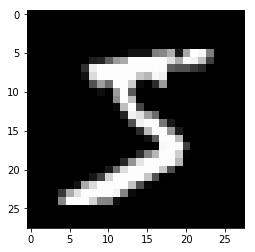

In [82]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(28,28), cmap='gray');
    
view_digit(data.train_x[0,:], data.train_y[0])

In [103]:
knn = Knearest (data.train_x, data.train_y)
cm = knn.confusion_matrix (data.test_x, data.test_y)
print("CONFUSION MATRIX :")
print(cm)

CONFUSION MATRIX :
[[ 983    0    3    0    0    0    2    1    0    2]
 [   0 1060    1    0    1    0    1    1    0    0]
 [   3    9  953    2    1    1    1   17    1    2]
 [   0    0    3 1007    0    6    1    4    6    3]
 [   0   10    1    0  941    0    0    6    0   25]
 [   2    2    1   17    2  863   17    3    3    5]
 [   1    0    0    0    0    1  965    0    0    0]
 [   0   10    0    0    3    0    0 1070    0    7]
 [   3    8    1   15    4   13    4    5  947    9]
 [   3    3    0   10   11    2    0    7    1  924]]


From the confusion matrix above, few of the following confusions are:
1. Confusing 2 for 7
2. Confusing 4 for 9

true label: 2


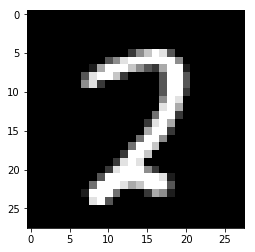

In [89]:
#Confusing 2 for 7
view_digit(data.test_x[229, :], data.test_y[229])

Here, 2 is getting confused for 7. The horizontal line of 2 is very short(number of points related to this is very less) and does not start at the end of the slant line of the 2 which makes it look more like 7.

true label: 4


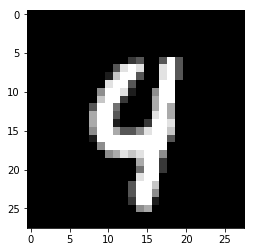

In [90]:
#Confusing 4 for 9
view_digit(data.test_x[712, :], data.test_y[712])

Here, 4 is getting confused for 9. The upper part of this image must look like a triangle for this image to look like 4 but instead it's almost an oval. This causes the nearest neighbour of this image to be 9 since the upper portion of 9 is like an oval/circle.